<a href="https://colab.research.google.com/github/ElDEEB21/Neuromatch-DL-2025/blob/main/Week_1/W1D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: PyTorch
**Week 1, Day 1: Basics and PyTorch**

**By Neuromatch Academy**


__Content creators:__ Shubh Pachchigar, Vladimir Haltakov, Matthew Sargent, Konrad Kording

__Content reviewers:__ Deepak Raya, Siwei Bai, Kelson Shilling-Scrivo

__Content editors:__ Anoop Kulkarni, Spiros Chavlis

__Production editors:__ Arush Tagade, Spiros Chavlis

---
# Tutorial Objectives

Then have a few specific objectives for this tutorial:
* Learn about PyTorch and tensors
* Tensor Manipulations
* Data Loading
* GPUs and CUDA Tensors
* Train NaiveNet
* Get to know your pod
* Start thinking about the course as a whole

In [81]:
# @title Tutorial slides
from IPython.display import IFrame
link_id = "wcjrv"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/wcjrv/


---
# Setup

Throughout your Neuromatch tutorials, most (probably all!) notebooks contain setup cells. These cells will import the required Python packages (e.g., PyTorch, NumPy); set global or environment variables, and load in helper functions for things like plotting. In some tutorials, you will notice that we install some dependencies even if they are preinstalled on Google Colab or Kaggle. This happens because we have added automation to our repository through [GitHub Actions](https://docs.github.com/en/actions/learn-github-actions/introduction-to-github-actions).

Be sure to run all of the cells in the setup section. Feel free to expand them and have a look at what you are loading in, but you should be able to fulfill the learning objectives of every tutorial without having to look at these cells.

If you start building your own projects built on this code base we highly recommend looking at them in more detail.

In [82]:
# @title Install dependencies
!pip install pandas --quiet

In [83]:
# @title Install and import feedback gadget
!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_dl",
            "user_key": "f379rz8y",
        },
    ).render()


feedback_prefix = "W1D1_T1"

In [84]:
# Imports
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch libraries
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [85]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [86]:
# @title Helper Functions

def checkExercise1(A, B, C, D):
  """
  Helper function for checking Exercise 1.

  Args:
    A: torch.Tensor
      Torch Tensor of shape (20, 21) consisting of ones.
    B: torch.Tensor
      Torch Tensor of size([3,4])
    C: torch.Tensor
      Torch Tensor of size([20,21])
    D: torch.Tensor
      Torch Tensor of size([19])

  Returns:
    Nothing.
  """
  assert torch.equal(A.to(int),torch.ones(20, 21).to(int)), "Got: {A} \n Expected: {torch.ones(20, 21)} (shape: {torch.ones(20, 21).shape})"
  assert np.array_equal(B.numpy(),np.vander([1, 2, 3], 4)), "Got: {B} \n Expected: {np.vander([1, 2, 3], 4)} (shape: {np.vander([1, 2, 3], 4).shape})"
  assert C.shape == (20, 21), "Got: {C} \n Expected (shape: {(20, 21)})"
  assert torch.equal(D, torch.arange(4, 41, step=2)), "Got {D} \n Expected: {torch.arange(4, 41, step=2)} (shape: {torch.arange(4, 41, step=2).shape})"
  print("All correct")

def timeFun(f, dim, iterations, device='cpu'):
  """
  Helper function to calculate amount of time taken per instance on CPU/GPU

  Args:
    f: BufferedReader IO instance
      Function name for which to calculate computational time complexity
    dim: Integer
      Number of dimensions in instance in question
    iterations: Integer
      Number of iterations for instance in question
    device: String
      Device on which respective computation is to be run

  Returns:
    Nothing
  """
  iterations = iterations
  t_total = 0
  for _ in range(iterations):
    start = time.time()
    f(dim, device)
    end = time.time()
    t_total += end - start

  if device == 'cpu':
    print(f"time taken for {iterations} iterations of {f.__name__}({dim}, {device}): {t_total:.5f}")
  else:
    print(f"time taken for {iterations} iterations of {f.__name__}({dim}, {device}): {t_total:.5f}")

**Important note: Colab users**

*Scratch Code Cells*

If you want to quickly try out something or take a look at the data, you can use scratch code cells. They allow you to run Python code, but will not mess up the structure of your notebook.

To open a new scratch cell go to *Insert* → *Scratch code cell*.

# Section 1: Welcome to Neuromatch Deep learning course

*Time estimate: ~25mins*

In [87]:
# @title Video 1: Welcome and History
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'ca21SNqt78I'), ('Bilibili', 'BV1Av411n7oL')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

This will be an intensive 3 week adventure. We will all learn Deep Learning (DL) in a group. Groups need standards. Read our
[Code of Conduct](https://docs.google.com/document/d/1eHKIkaNbAlbx_92tLQelXnicKXEcvFzlyzzeWjEtifM/edit?usp=sharing).


In [88]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Welcome_and_History_Video")

In [89]:
# @title Video 2: Why DL is cool
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'l-K6495BN-4'), ('Bilibili', 'BV1gf4y1j7UZ')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

**Discuss with your pod: What do you hope to get out of this course? [in about 100 words]**

In [90]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Why_DL_is_cool_Video")

---
# Section 2: The Basics of PyTorch

*Time estimate: ~2 hours 05 mins*

PyTorch is a Python-based scientific computing package targeted at two sets of
audiences:

-  A replacement for NumPy optimized for the power of GPUs
-  A deep learning platform that provides significant flexibility
   and speed

At its core, PyTorch provides a few key features:

- A multidimensional [Tensor](https://pytorch.org/docs/stable/tensors.html) object, similar to [NumPy Array](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) but with GPU acceleration.
- An optimized **autograd** engine for automatically computing derivatives.
- A clean, modular API for building and deploying **deep learning models**.

You can find more information about PyTorch in the Appendix.

## Section 2.1: Creating Tensors


In [91]:
# @title Video 3: Making Tensors
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'jGKd_4tPGrw'), ('Bilibili', 'BV1Rw411d7Uy')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [92]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Making_Tensors_Video")

There are various ways of creating tensors, and when doing any real deep learning project, we will usually have to do so.

**Construct tensors directly:**

---



In [93]:
# We can construct a tensor directly from some common python iterables,
# such as list and tuple nested iterables can also be handled as long as the
# dimensions are compatible

# tensor from a list
a = torch.tensor([0, 1, 2])

#tensor from a tuple of tuples
b = ((1.0, 1.1), (1.2, 1.3))
b = torch.tensor(b)

# tensor from a numpy array
c = np.ones([2, 3])
c = torch.tensor(c)

print(f"Tensor a: {a}")
print(f"Tensor b: {b}")
print(f"Tensor c: {c}")

Tensor a: tensor([0, 1, 2])
Tensor b: tensor([[1.0000, 1.1000],
        [1.2000, 1.3000]])
Tensor c: tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)


**Some common tensor constructors:**

---

In [94]:
# The numerical arguments we pass to these constructors
# determine the shape of the output tensor

x = torch.ones(5, 3)
y = torch.zeros(2)
z = torch.empty(1, 1, 5)
print(f"Tensor x: {x}")
print(f"Tensor y: {y}")
print(f"Tensor z: {z}")

Tensor x: tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
Tensor y: tensor([0., 0.])
Tensor z: tensor([[[1.4625e+00, 0.0000e+00, 0.0000e+00, 1.4013e-45, 0.0000e+00]]])


Notice that `.empty()` does not return zeros, but seemingly random numbers. Unlike `.zeros()`, which initialises the elements of the tensor with zeros, `.empty()` just allocates the memory. It is hence a bit faster if you are looking to just create a tensor.

**Creating random tensors and tensors like other tensors:**

---

In [95]:
# There are also constructors for random numbers

# Uniform distribution
a = torch.rand(1, 3)

# Normal distribution
b = torch.randn(3, 4)

# There are also constructors that allow us to construct
# a tensor according to the above constructors, but with
# dimensions equal to another tensor.

c = torch.zeros_like(a)
d = torch.rand_like(c)

print(f"Tensor a: {a}")
print(f"Tensor b: {b}")
print(f"Tensor c: {c}")
print(f"Tensor d: {d}")

Tensor a: tensor([[0.1304, 0.5134, 0.7426]])
Tensor b: tensor([[-0.1264, -0.8728, -0.5257, -1.6962],
        [ 2.0921,  2.3756,  0.7233, -0.6263],
        [ 0.9398, -0.4874,  0.8895,  0.1104]])
Tensor c: tensor([[0., 0., 0.]])
Tensor d: tensor([[0.0604, 0.1773, 0.3301]])


*Reproducibility*:

- PyTorch Random Number Generator (RNG): You can use `torch.manual_seed()` to seed the RNG for all devices (both CPU and GPU):

```python
import torch
torch.manual_seed(0)
```
- For custom operators, you might need to set python seed as well:

```python
import random
random.seed(0)
```

- Random number generators in other libraries (e.g., NumPy):

```python
import numpy as np
np.random.seed(0)
```

Here, we define for you a function called `set_seed` that does the job for you!

In [96]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

Now, let's use the `set_seed` function in the previous example. Execute the cell multiple times to verify that the numbers printed are always the same.

In [97]:
def simplefun(seed=True, my_seed=None):
  """
  Helper function to verify effectiveness of set_seed attribute

  Args:
    seed: Boolean
      Specifies if seed value is provided or not
    my_seed: Integer
      Initializes seed to specified value

  Returns:
    Nothing
  """
  if seed:
    set_seed(seed=my_seed)

  # uniform distribution
  a = torch.rand(1, 3)
  # normal distribution
  b = torch.randn(3, 4)

  print("Tensor a: ", a)
  print("Tensor b: ", b)

In [98]:
simplefun(seed=True, my_seed=1)  # Turn `seed` to `False` or change `my_seed`

Random seed 1 has been set.
Tensor a:  tensor([[0.7576, 0.2793, 0.4031]])
Tensor b:  tensor([[ 0.7244, -0.7022,  1.1661,  0.2605],
        [ 0.3506,  1.0203, -1.8349, -2.2149],
        [ 0.0436,  1.3240, -0.1005,  0.6443]])


**Numpy-like number ranges:**
---
The ```.arange()``` and ```.linspace()``` behave how you would expect them to if you are familar with numpy.

In [99]:
a = torch.arange(0, 10, step=1)
b = np.arange(0, 10, step=1)

c = torch.linspace(0, 5, steps=11)
d = np.linspace(0, 5, num=11)

print(f"Tensor a: {a}\n")
print(f"Numpy array b: {b}\n")
print(f"Tensor c: {c}\n")
print(f"Numpy array d: {d}\n")

Tensor a: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Numpy array b: [0 1 2 3 4 5 6 7 8 9]

Tensor c: tensor([0.0000, 0.5000, 1.0000, 1.5000, 2.0000, 2.5000, 3.0000, 3.5000, 4.0000,
        4.5000, 5.0000])

Numpy array d: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]



### Coding Exercise 2.1: Creating Tensors

Below you will find some incomplete code. Fill in the missing code to construct the specified tensors.

We want the tensors:

$A:$ 20 by 21 tensor consisting of ones

$B:$ a tensor with elements equal to the elements of numpy array $Z$

$C:$ a tensor with the same number of elements as $A$ but with values $
\sim \mathcal{U}(0,1)^\dagger$

$D:$ a 1D tensor containing the even numbers between 4 and 40 inclusive.

<br>

$^\dagger$: $\mathcal{U(\alpha, \beta)}$ denotes the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution) from $\alpha$ to $\beta$, with $\alpha, \beta \in \mathbb{R}$.


In [100]:
def tensor_creation(Z):
  """
  A function that creates various tensors.

  Args:
    Z: numpy.ndarray
      An array of shape (3,4)

  Returns:
    A : Tensor
      20 by 21 tensor consisting of ones
    B : Tensor
      A tensor with elements equal to the elements of numpy array Z
    C : Tensor
      A tensor with the same number of elements as A but with values ∼U(0,1)
    D : Tensor
      A 1D tensor containing the even numbers between 4 and 40 inclusive.
  """
  #################################################
  ## TODO for students: fill in the missing code
  ## from the first expression
  # raise NotImplementedError("Student exercise: say what they should have done")
  #################################################
  A = torch.ones(20,21)
  B = torch.tensor(Z)
  C = torch.rand_like(A)
  D = torch.arange(4,41,2)

  return A, B, C, D


# numpy array to copy later
Z = np.vander([1, 2, 3], 4)

# Uncomment below to check your function!
A, B, C, D = tensor_creation(Z)
checkExercise1(A, B, C, D)

All correct


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D1_BasicsAndPytorch/solutions/W1D1_Tutorial1_Solution_7137e978.py)



```
All correct!
```

In [101]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Creating_Tensors_Exercise")

## Section 2.2: Operations in PyTorch

**Tensor-Tensor operations**

We can perform operations on tensors using methods under `torch.`

In [102]:
# @title Video 4: Tensor Operators
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'R1R8VoYXBVA'), ('Bilibili', 'BV1G44y127As')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [103]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Tensors_Operators_Video")

**Tensor-Tensor operations**

We can perform operations on tensors using methods under `torch.`.

In [104]:
a = torch.ones(5, 3)
b = torch.rand(5, 3)
c = torch.empty(5, 3)
d = torch.empty(5, 3)

# this only works if c and d already exist
torch.add(a, b, out=c)

# Pointwise Multiplication of a and b
torch.multiply(a, b, out=d)

print(c)
print(d)

tensor([[1.8006, 1.2526, 1.0581],
        [1.6675, 1.7737, 1.9956],
        [1.4477, 1.9810, 1.8212],
        [1.2520, 1.1143, 1.7804],
        [1.2261, 1.7293, 1.0718]])
tensor([[0.8006, 0.2526, 0.0581],
        [0.6675, 0.7737, 0.9956],
        [0.4477, 0.9810, 0.8212],
        [0.2520, 0.1143, 0.7804],
        [0.2261, 0.7293, 0.0718]])


However, in PyTorch, most common Python operators are overridden.
The common standard arithmetic operators ($+$, $-$, $*$, $/$, and $**$) have all been lifted to elementwise operations

In [105]:
x = torch.tensor([1, 2, 4, 8])
y = torch.tensor([1, 2, 3, 4])
x + y, x - y, x * y, x / y, x**y  # The `**` is the exponentiation operator

(tensor([ 2,  4,  7, 12]),
 tensor([0, 0, 1, 4]),
 tensor([ 1,  4, 12, 32]),
 tensor([1.0000, 1.0000, 1.3333, 2.0000]),
 tensor([   1,    4,   64, 4096]))

**Tensor Methods**

Tensors also have a number of common arithmetic operations built in. A full list of **all** methods can be found  in the appendix (there are a lot!)

All of these operations should have similar syntax to their numpy equivalents (feel free to skip if you already know this!).

In [106]:
x = torch.rand(3, 3)
print(x)
print("\n")
# sum() - note the axis is the axis you move across when summing
print(f"Sum of every element of x: {x.sum()}")
print(f"Sum of the columns of x: {x.sum(axis=0)}")
print(f"Sum of the rows of x: {x.sum(axis=1)}")
print("\n")

print(f"Mean value of all elements of x {x.mean()}")
print(f"Mean values of the columns of x {x.mean(axis=0)}")
print(f"Mean values of the rows of x {x.mean(axis=1)}")

tensor([[0.8648, 0.6499, 0.4425],
        [0.7293, 0.1440, 0.3907],
        [0.5049, 0.2111, 0.3722]])


Sum of every element of x: 4.309427261352539
Sum of the columns of x: tensor([2.0990, 1.0050, 1.2055])
Sum of the rows of x: tensor([1.9572, 1.2640, 1.0882])


Mean value of all elements of x 0.47882524132728577
Mean values of the columns of x tensor([0.6997, 0.3350, 0.4018])
Mean values of the rows of x tensor([0.6524, 0.4213, 0.3627])


**Matrix Operations**

The `@` symbol is overridden to represent matrix multiplication. You can also use `torch.matmul()` to multiply tensors. For dot multiplication, you can use `torch.dot()`, or manipulate the axes of your tensors and do matrix multiplication (we will cover that in the next section).

Transposes of 2D tensors are obtained using `torch.t()` or `Tensor.T`. Note the lack of brackets for `Tensor.T` - it is an attribute, not a method.



### Coding Exercise 2.2 : Simple tensor operations

Below are two expressions involving operations on matrices.

\begin{equation}
\textbf{A} =
\begin{bmatrix}2 &4 \\5 & 7
\end{bmatrix}
\begin{bmatrix} 1 &1 \\2 & 3
\end{bmatrix}
+
\begin{bmatrix}10 & 10  \\ 12 & 1
\end{bmatrix}
\end{equation}


and


\begin{equation}
b =
\begin{bmatrix} 3 \\ 5 \\ 7
\end{bmatrix} \cdot
\begin{bmatrix} 2 \\ 4 \\ 8
\end{bmatrix}
\end{equation}

The code block below that computes these expressions using PyTorch is incomplete - fill in the missing lines.

In [107]:
def simple_operations(a1: torch.Tensor, a2: torch.Tensor, a3: torch.Tensor):
  """
  Helper function to demonstrate simple operations
  i.e., Multiplication of tensor a1 with tensor a2 and then add it with tensor a3

  Args:
    a1: Torch tensor
      Tensor of size ([2,2])
    a2: Torch tensor
      Tensor of size ([2,2])
    a3: Torch tensor
      Tensor of size ([2,2])

  Returns:
    answer: Torch tensor
      Tensor of size ([2,2]) resulting from a1 multiplied with a2, added with a3
  """
  ################################################
  ## TODO for students:  complete the first computation using the argument matricies
  # raise NotImplementedError("Student exercise: fill in the missing code to complete the operation")
  ################################################
  #
  answer = a1 @ a2 + a3
  return answer


# Computing expression 1:

# init our tensors
a1 = torch.tensor([[2, 4], [5, 7]])
a2 = torch.tensor([[1, 1], [2, 3]])
a3 = torch.tensor([[10, 10], [12, 1]])
## uncomment to test your function
A = simple_operations(a1, a2, a3)
print(A)

tensor([[20, 24],
        [31, 27]])


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D1_BasicsAndPytorch/solutions/W1D1_Tutorial1_Solution_10c96625.py)



```
tensor([[20, 24],
        [31, 27]])
```

In [108]:
def dot_product(b1: torch.Tensor, b2: torch.Tensor):
  ###############################################
  ## TODO for students:  complete the first computation using the argument matricies
  # raise NotImplementedError("Student exercise: fill in the missing code to complete the operation")
  ###############################################
  """
  Helper function to demonstrate dot product operation
  Dot product is an algebraic operation that takes two equal-length sequences
  (usually coordinate vectors), and returns a single number.
  Geometrically, it is the product of the Euclidean magnitudes of the
  two vectors and the cosine of the angle between them.

  Args:
    b1: Torch tensor
      Tensor of size ([3])
    b2: Torch tensor
      Tensor of size ([3])

  Returns:
    product: Tensor
      Tensor of size ([1]) resulting from b1 scalar multiplied with b2
  """
  # Use torch.dot() to compute the dot product of two tensors
  product = torch.dot(b1, b2)
  return product


# Computing expression 2:
b1 = torch.tensor([3, 5, 7])
b2 = torch.tensor([2, 4, 8])
## Uncomment to test your function
b = dot_product(b1, b2)
print(b)

tensor(82)


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D1_BasicsAndPytorch/solutions/W1D1_Tutorial1_Solution_84663577.py)



```
tensor(82)
```

In [109]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Simple_Tensor_Operations_Exercise")

## Section 2.3 Manipulating Tensors in Pytorch

In [110]:
# @title Video 5: Tensor Indexing
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '0d0KSJ3lJbg'), ('Bilibili', 'BV1BM4y1K7pD')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [111]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Manipulating_Tensors_Video")

**Indexing**

Just as in numpy, elements in a tensor can be accessed by index. As in any numpy array, the first element has index 0 and ranges are specified to include the first to last_element-1. We can access elements according to their relative position to the end of the list by using negative indices. Indexing is also referred to as slicing.

For example, `[-1]` selects the last element; `[1:3]` selects the second and the third elements, and `[:-2]` will select all elements excluding the last and second-to-last elements.

In [112]:
x = torch.arange(0, 10)
print(x)
print(x[-1])
print(x[1:3])
print(x[:-2])

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor(9)
tensor([1, 2])
tensor([0, 1, 2, 3, 4, 5, 6, 7])


When we have multidimensional tensors, indexing rules work the same way as NumPy.

In [113]:
# make a 5D tensor
x = torch.rand(1, 2, 3, 4, 5)

print(f" shape of x[0]:{x[0].shape}")
print(f" shape of x[0][0]:{x[0][0].shape}")
print(f" shape of x[0][0][0]:{x[0][0][0].shape}")

 shape of x[0]:torch.Size([2, 3, 4, 5])
 shape of x[0][0]:torch.Size([3, 4, 5])
 shape of x[0][0][0]:torch.Size([4, 5])


**Flatten and reshape**

There are various methods for reshaping tensors. It is common to have to express 2D data in 1D format. Similarly, it is also common to have to reshape a 1D tensor into a 2D tensor. We can achieve this with the `.flatten()` and `.reshape()` methods.

In [114]:
z = torch.arange(12).reshape(6, 2)
print(f"Original z: \n {z}")

# 2D -> 1D
z = z.flatten()
print(f"Flattened z: \n {z}")

# and back to 2D
z = z.reshape(3, 4)
print(f"Reshaped (3x4) z: \n {z}")

Original z: 
 tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]])
Flattened z: 
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Reshaped (3x4) z: 
 tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


You will also see the `.view()` methods used a lot to reshape tensors. There is a subtle difference between `.view()` and `.reshape()`, though for now we will just use `.reshape()`. The documentation can be found in the Appendix.

**Squeezing tensors**

When processing batches of data, you will quite often be left with singleton dimensions. E.g., `[1,10]` or `[256, 1, 3]`. This dimension can quite easily mess up your matrix operations if you don't plan on it being there...

In order to compress tensors along their singleton dimensions we can use the `.squeeze()` method. We can use the `.unsqueeze()` method to do the opposite.

In [115]:
x = torch.randn(1, 10)
# printing the zeroth element of the tensor will not give us the first number!

print(x.shape)
print(f"x[0]: {x[0]}")

torch.Size([1, 10])
x[0]: tensor([ 0.2171, -0.7028,  1.6201, -2.0630,  1.4201, -0.6445,  0.0388, -0.9435,
         0.0120, -1.4350])


Because of that pesky singleton dimension, `x[0]` gave us the first row instead!

In [116]:
# Let's get rid of that singleton dimension and see what happens now
x = x.squeeze(0)
print(x.shape)
print(f"x[0]: {x[0]}")

torch.Size([10])
x[0]: 0.21709439158439636


In [117]:
# Adding singleton dimensions works a similar way, and is often used when tensors
# being added need same number of dimensions

y = torch.randn(5, 5)
print(f"Shape of y: {y.shape}")

# lets insert a singleton dimension
y = y.unsqueeze(1)
print(f"Shape of y: {y.shape}")

Shape of y: torch.Size([5, 5])
Shape of y: torch.Size([5, 1, 5])


**Permutation**

Sometimes our dimensions will be in the wrong order! For example, we may be dealing with RGB images with dim $[3\times48\times64]$, but our pipeline expects the colour dimension to be the last dimension, i.e., $[48\times64\times3]$. To get around this we can use the `.permute()` method.

In [118]:
# `x` has dimensions [color,image_height,image_width]
x = torch.rand(3, 48, 64)

# We want to permute our tensor to be [ image_height , image_width , color ]
x = x.permute(1, 2, 0)
# permute(1,2,0) means:
# The 0th dim of my new tensor = the 1st dim of my old tensor
# The 1st dim of my new tensor = the 2nd
# The 2nd dim of my new tensor = the 0th
print(x.shape)

torch.Size([48, 64, 3])


You may also see `.transpose()` used. This works in a similar way as permute, but can only swap two dimensions at once.

**Concatenation**

In this example, we concatenate two matrices along rows (axis 0, the first element of the shape) vs. columns (axis 1, the second element of the shape). We can see that the first output tensor’s axis-0 length (`6`) is the sum of the two input tensors’ axis-0 lengths (`3+3`); while the second output tensor’s axis-1 length (`8`) is the sum of the two input tensors’ axis-1 lengths (`4+4`).

In [119]:
# Create two tensors of the same shape
x = torch.arange(12, dtype=torch.float32).reshape((3, 4))
y = torch.tensor([[2.0, 1, 4, 3], [1, 2, 3, 4], [4, 3, 2, 1]])

# Concatenate along rows
cat_rows = torch.cat((x, y), dim=0)

# Concatenate along columns
cat_cols = torch.cat((x, y), dim=1)

# Printing outputs
print('Concatenated by rows: shape{} \n {}'.format(list(cat_rows.shape), cat_rows))
print('\n Concatenated by colums: shape{}  \n {}'.format(list(cat_cols.shape), cat_cols))

Concatenated by rows: shape[6, 4] 
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [ 2.,  1.,  4.,  3.],
        [ 1.,  2.,  3.,  4.],
        [ 4.,  3.,  2.,  1.]])

 Concatenated by colums: shape[3, 8]  
 tensor([[ 0.,  1.,  2.,  3.,  2.,  1.,  4.,  3.],
        [ 4.,  5.,  6.,  7.,  1.,  2.,  3.,  4.],
        [ 8.,  9., 10., 11.,  4.,  3.,  2.,  1.]])


**Conversion to Other Python Objects**

Converting a tensor to a numpy.ndarray, or vice versa, is easy, and the converted result does not share memory. This minor inconvenience is quite important: when you perform operations on the CPU or GPUs, you do not want to halt computation, waiting to see whether the NumPy package of Python might want to be doing something else with the same chunk of memory.

When converting to a NumPy array, the information being tracked by the tensor will be lost, i.e., the computational graph. This will be covered in detail when you are introduced to autograd tomorrow!

In [120]:
x = torch.randn(5)
print(f"x: {x}  |  x type:  {x.type()}")

y = x.numpy()
print(f"y: {y}  |  y type:  {type(y)}")

z = torch.tensor(y)
print(f"z: {z}  |  z type:  {z.type()}")

x: tensor([-0.6725, -1.8442, -1.1618,  0.3361,  0.4001])  |  x type:  torch.FloatTensor
y: [-0.6724866  -1.8441505  -1.1618328   0.33612037  0.40007737]  |  y type:  <class 'numpy.ndarray'>
z: tensor([-0.6725, -1.8442, -1.1618,  0.3361,  0.4001])  |  z type:  torch.FloatTensor


To convert a size-1 tensor to a Python scalar, we can invoke the item function or Python’s built-in functions.

In [121]:
a = torch.tensor([3.5])
a, a.item(), float(a), int(a)

(tensor([3.5000]), 3.5, 3.5, 3)

### Coding Exercise 2.3: Manipulating Tensors
Using a combination of the methods discussed above, complete the functions below.

**Function A**

This function takes in two 2D tensors $A$ and $B$ and returns the column sum of A multiplied by the sum of all the elmements of $B$, i.e., a scalar, e.g.,

\begin{equation}
  \text{If }
  A = \begin{bmatrix}
  1 & 1 \\
  1 & 1
  \end{bmatrix}
  \text{and }
  B = \begin{bmatrix}
  1 & 2 & 3 \\
  1 & 2 & 3
  \end{bmatrix}
  \text{ then }
  Out =  \begin{bmatrix}
  2 & 2
  \end{bmatrix} \cdot 12 = \begin{bmatrix}
  24 & 24
  \end{bmatrix}
\end{equation}

**Function B**

This function takes in a square matrix $C$ and returns a 2D tensor consisting of a flattened $C$ with the index of each element appended to this tensor in the row dimension, e.g.,

\begin{equation}
  \text{If }
  C = \begin{bmatrix}
  2 & 3 \\
  -1 & 10
  \end{bmatrix}
  \text{ then }
  Out = \begin{bmatrix}
  0 & 2 \\
  1 & 3 \\
  2 & -1 \\
  3 & 10
  \end{bmatrix}
\end{equation}

**Hint:** Pay close attention to singleton dimensions.

**Function C**

This function takes in two 2D tensors $D$ and $E$. If the dimensions allow it, this function returns the elementwise sum of $D$-shaped $E$, and $D$; else this function returns a 1D tensor that is the concatenation of the two tensors, e.g.,

\begin{equation}
  \text{If }
  D = \begin{bmatrix}
  1 & -1 \\
  -1 & 3
  \end{bmatrix}
  \text{and }
  E = \begin{bmatrix}
  2 & 3 & 0 & 2 \\
  \end{bmatrix}
  \text{ then }
  Out = \begin{bmatrix}
  3 & 2 \\
  -1 & 5
  \end{bmatrix}
\end{equation}

<br>

\begin{equation}
  \text{If }
  D = \begin{bmatrix}
  1 & -1 \\
  -1 & 3
  \end{bmatrix}
  \text{and }
  E = \begin{bmatrix}
  2 & 3 & 0  \\
  \end{bmatrix}
  \text{ then }
  Out = \begin{bmatrix}
  1 & -1 & -1 & 3  & 2 & 3 & 0
  \end{bmatrix}
\end{equation}

<br>

**Hint:** `torch.numel()` is an easy way of finding the number of elements in a tensor.

In [122]:
def functionA(my_tensor1, my_tensor2):
  """
  This function takes in two 2D tensors `my_tensor1` and `my_tensor2`
  and returns the column sum of
  `my_tensor1` multiplied by the sum of all the elmements of `my_tensor2`,
  i.e., a scalar.

  Args:
    my_tensor1: torch.Tensor
    my_tensor2: torch.Tensor

  Retuns:
    output: torch.Tensor
      The multiplication of the column sum of `my_tensor1` by the sum of
      `my_tensor2`.
  """
  ################################################
  ## TODO for students: complete functionA
  # raise NotImplementedError("Student exercise: complete function A")
  ################################################
  # TODO multiplication the sum of the tensors
  output = my_tensor1.sum(1) * my_tensor2.sum()

  return output


def functionB(my_tensor):
  """
  This function takes in a square matrix `my_tensor` and returns a 2D tensor
  consisting of a flattened `my_tensor` with the index of each element
  appended to this tensor in the row dimension.

  Args:
    my_tensor: torch.Tensor

  Returns:
    output: torch.Tensor
      Concatenated tensor.
  """
  ################################################
  ## TODO for students: complete functionB
  # raise NotImplementedError("Student exercise: complete function B")
  ################################################
  # TODO flatten the tensor `my_tensor`
  my_tensor = my_tensor.flatten()
  # TODO create the idx tensor to be concatenated to `my_tensor`
  idx_tensor = torch.arange(my_tensor.numel())
  # TODO concatenate the two tensors
  output = torch.stack((idx_tensor, my_tensor), dim=1)

  return output


def functionC(my_tensor1, my_tensor2):
  """
  This function takes in two 2D tensors `my_tensor1` and `my_tensor2`.
  If the dimensions allow it, it returns the
  elementwise sum of `my_tensor1`-shaped `my_tensor2`, and `my_tensor2`;
  else this function returns a 1D tensor that is the concatenation of the
  two tensors.

  Args:
    my_tensor1: torch.Tensor
    my_tensor2: torch.Tensor

  Returns:
    output: torch.Tensor
      Concatenated tensor.
  """
  ################################################
  ## TODO for students: complete functionB
  # raise NotImplementedError("Student exercise: complete function C")
  ################################################
  # TODO check we can reshape `my_tensor2` into the shape of `my_tensor1`
  if my_tensor1.numel() == my_tensor2.numel():
    # TODO reshape `my_tensor2` into the shape of `my_tensor1`
    my_tensor2 = my_tensor2.reshape(my_tensor1.shape)
    # TODO sum the two tensors
    output = my_tensor1 + my_tensor2
  else:
    # TODO flatten both tensors
    my_tensor1 = my_tensor1.flatten()
    my_tensor2 = my_tensor2.flatten()
    # TODO concatenate the two tensors in the correct dimension
    output = torch.cat((my_tensor1, my_tensor2), dim=0)

  return output


## Implement the functions above and then uncomment the following lines to test your code
print(functionA(torch.tensor([[1, 1], [1, 1]]), torch.tensor([[1, 2, 3], [1, 2, 3]])))
print(functionB(torch.tensor([[2, 3], [-1, 10]])))
print(functionC(torch.tensor([[1, -1], [-1, 3]]), torch.tensor([[2, 3, 0, 2]])))
print(functionC(torch.tensor([[1, -1], [-1, 3]]), torch.tensor([[2, 3, 0]])))

tensor([24, 24])
tensor([[ 0,  2],
        [ 1,  3],
        [ 2, -1],
        [ 3, 10]])
tensor([[ 3,  2],
        [-1,  5]])
tensor([ 1, -1, -1,  3,  2,  3,  0])


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D1_BasicsAndPytorch/solutions/W1D1_Tutorial1_Solution_234c6f74.py)



```
tensor([24, 24])
tensor([[ 0,  2],
        [ 1,  3],
        [ 2, -1],
        [ 3, 10]])
tensor([[ 3,  2],
        [-1,  5]])
tensor([ 1, -1, -1,  3,  2,  3,  0])
```

In [123]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Manipulating_Tensors_Exercise")

## Section 2.4: GPUs

In [124]:
# @title Video 6: GPU vs CPU
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '9Mc9GFUtILY'), ('Bilibili', 'BV1nM4y1K7qx')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [125]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_GPU_vs_CPU_Video")


By default, when we create a tensor it will *not* live on the GPU!

In [126]:
x = torch.randn(10)
print(x.device)

cpu


When using Colab notebooks, by default, will not have access to a GPU. In order to start using GPUs we need to request one. We can do this by going to the runtime tab at the top of the page.

By following *Runtime* → *Change runtime type* and selecting **GPU** from the *Hardware Accelerator* dropdown list, we can start playing with sending tensors to GPUs.

Once you have done this your runtime will restart and you will need to rerun the first setup cell to reimport PyTorch. Then proceed to the next cell.

For more information on the GPU usage policy you can view in the Appendix.

**Now we have a GPU.**


The cell below should return `True`.

In [127]:
print(torch.cuda.is_available())

False


[CUDA](https://developer.nvidia.com/cuda-toolkit) is an API developed by Nvidia for interfacing with GPUs. PyTorch provides us with a layer of abstraction, and allows us to launch CUDA kernels using pure Python.

In short, we get the power of parallelizing our tensor computations on GPUs, whilst only writing (relatively) simple Python!

Here, we define the function `set_device`, which returns the device use in the notebook, i.e., `cpu` or `cuda`. Unless otherwise specified, we use this function on top of every tutorial, and we store the device variable such as

```python
DEVICE = set_device()
```

Let's define the function using the PyTorch package `torch.cuda`, which is lazily initialized, so we can always import it, and use `is_available()` to determine if our system supports CUDA.

In [128]:
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

Let's make some CUDA tensors!

In [129]:
# common device agnostic way of writing code that can run on cpu OR gpu
# that we provide for you in each of the tutorials
DEVICE = set_device()

# we can specify a device when we first create our tensor
x = torch.randn(2, 2, device=DEVICE)
print(x.dtype)
print(x.device)

# we can also use the .to() method to change the device a tensor lives on
y = torch.randn(2, 2)
print(f"y before calling to() | device: {y.device} | dtype: {y.type()}")

y = y.to(DEVICE)
print(f"y after calling to() | device: {y.device} | dtype: {y.type()}")

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu
torch.float32
cpu
y before calling to() | device: cpu | dtype: torch.FloatTensor
y after calling to() | device: cpu | dtype: torch.FloatTensor


**Operations between cpu tensors and cuda tensors**

Note that the type of the tensor changed after calling `.to()`. What happens if we try and perform operations on tensors on devices?

In [130]:
x = torch.tensor([0, 1, 2], device=DEVICE)
y = torch.tensor([3, 4, 5], device="cpu")

## Uncomment the following line and run this cell
z = x + y

We cannot combine CUDA tensors and CPU tensors in this fashion. If we want to compute an operation that combines tensors on different devices, we need to move them first! We can use the `.to()` method as before, or the `.cpu()` and `.cuda()` methods. Note that using the `.cuda()` will throw an error, if CUDA is not enabled in your machine.

Generally, in this course, all Deep Learning is done on the GPU, and any computation is done on the CPU, so sometimes we have to pass things back and forth, so you'll see us call.

In [131]:
x = torch.tensor([0, 1, 2], device=DEVICE)
y = torch.tensor([3, 4, 5], device="cpu")
z = torch.tensor([6, 7, 8], device=DEVICE)

# moving to cpu
x = x.to("cpu")  # alternatively, you can use x = x.cpu()
print(x + y)

# moving to gpu
y = y.to(DEVICE)  # alternatively, you can use y = y.cuda()
print(y + z)

tensor([3, 5, 7])
tensor([ 9, 11, 13])


### Coding Exercise 2.4: Just how much faster are GPUs?

Below is a simple function `simpleFun`. Complete this function, such that it performs the operations:

- Elementwise multiplication

- Matrix multiplication

The operations should be able to perfomed on either the CPU or GPU specified by the parameter `device`. We will use the helper function `timeFun(f, dim, iterations, device)`.

In [132]:
dim = 10000
iterations = 1

In [133]:
def simpleFun(dim, device):
  """
  Helper function to check device-compatiblity with computations

  Args:
    dim: Integer
    device: String
      "cpu" or "cuda"

  Returns:
    Nothing.
  """
  # 2D tensor filled with uniform random numbers in [0,1), dim x dim
  x = torch.rand(dim, dim).to(device)
  # 2D tensor filled with uniform random numbers in [0,1), dim x dim
  y = torch.rand_like(x).to(device)
  # 2D tensor filled with the scalar value 2, dim x dim
  z = 2*torch.ones(dim, dim).to(device)

  # elementwise multiplication of x and y
  a = x * y
  # matrix multiplication of x and z
  b = x @ z

  del x
  del y
  del z
  del a
  del b


## Implement the function above and uncomment the following lines to test your code
timeFun(f=simpleFun, dim=dim, iterations=iterations)
timeFun(f=simpleFun, dim=dim, iterations=iterations, device=DEVICE)

time taken for 1 iterations of simpleFun(10000, cpu): 52.81583
time taken for 1 iterations of simpleFun(10000, cpu): 39.06613


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D1_BasicsAndPytorch/solutions/W1D1_Tutorial1_Solution_bb83a0e6.py)



Sample output (depends on your hardware)

```
time taken for 1 iterations of simpleFun(10000, cpu): 23.74070
time taken for 1 iterations of simpleFun(10000, cuda): 0.87535
```

In [134]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_How_Much_Faster_Are_GPUs_Exercise")

**Discuss!**

Try and reduce the dimensions of the tensors and increase the iterations. You can get to a point where the cpu only function is faster than the GPU function. Why might this be?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D1_BasicsAndPytorch/solutions/W1D1_Tutorial1_Solution_4ee0dee3.py)



In [135]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_GPUs_Discussion")

## Section 2.5: Datasets and Dataloaders

In [136]:
# @title Video 7: Getting Data
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'LSkjPM1gFu0'), ('Bilibili', 'BV1744y127SQ')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [137]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Getting_Data_Video")

When training neural network models you will be working with large amounts of data. Fortunately, PyTorch offers some great tools that help you organize and manipulate your data samples.

In [138]:
# Import dataset and dataloaders related packages
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Grayscale

**Datasets**

The `torchvision` package gives you easy access to many of the publicly available datasets. Let's load the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which contains color images of 10 different classes, like vehicles and animals.

Creating an object of type `datasets.CIFAR10` will automatically download and load all images from the dataset. The resulting data structure can be treated as a list containing data samples and their corresponding labels.

In [139]:
# Download and load the images from the CIFAR10 dataset
cifar10_data = datasets.CIFAR10(
    root="data",  # path where the images will be stored
    download=True,  # all images should be downloaded
    transform=ToTensor()  # transform the images to tensors
    )

# Print the number of samples in the loaded dataset
print(f"Number of samples: {len(cifar10_data)}")
print(f"Class names: {cifar10_data.classes}")

Number of samples: 50000
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


We have 50,000 samples loaded. Now, let's take a look at one of them in detail. Each sample consists of an image and its corresponding label.

In [140]:
# Choose a random sample
random.seed(2021)
image, label = cifar10_data[random.randint(0, len(cifar10_data))]
print(f"Label: {cifar10_data.classes[label]}")
print(f"Image size: {image.shape}")

Label: horse
Image size: torch.Size([3, 32, 32])


Color images are modeled as 3 dimensional tensors. The first dimension corresponds to the channels ($\text{C}$) of the image (in this case we have RGB images). The second dimensions is the height ($\text{H}$) of the image and the third is the width ($\text{W}$). We can denote this image format as $\text{C} \times \text{H} \times \text{W}$.

### Coding Exercise 2.5: Display an image from the dataset

Let's try to display the image using `matplotlib`. The code below will not work, because `imshow` expects to have the image in a different format, i.e., $\text{C} \times \text{H} \times \text{W}$.

You need to reorder the dimensions of the tensor using the `permute` method of the tensor. PyTorch `torch.permute(*dims)` rearranges the original tensor according to the desired ordering and returns a new multidimensional rotated tensor. The size of the returned tensor remains the same as that of the original.

**Code hint:**

```python
# create a tensor of size 2 x 4
input_var = torch.randn(2, 4)
# print its size and the tensor
print(input_var.size())
print(input_var)

# dimensions permuted
input_var = input_var.permute(1, 0)
# print its size and the permuted tensor
print(input_var.size())
print(input_var)
```

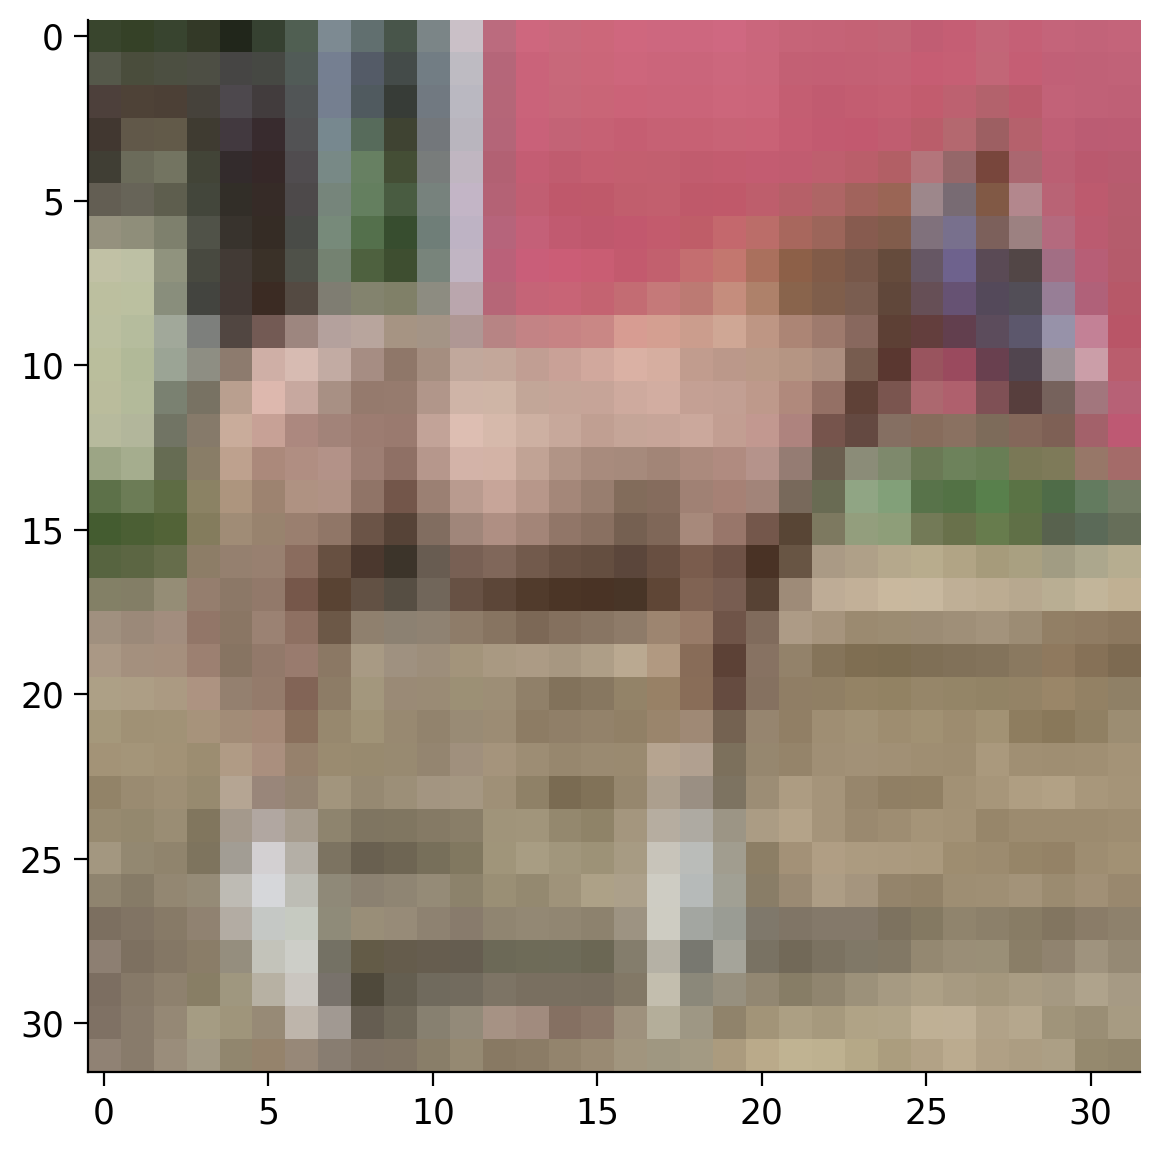

In [141]:
# TODO: Uncomment the following line to see the error that arises from the current image format
#plt.imshow(image)

# TODO: Comment the above line and fix this code by reordering the tensor dimensions
plt.imshow(image.permute(1, 2, 0))
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D1_BasicsAndPytorch/solutions/W1D1_Tutorial1_Solution_b04bd357.py)

*Example output:*

<img alt='Solution hint' align='left' width=580.0 height=575.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D1_BasicsAndPytorch/static/W1D1_Tutorial1_Solution_b04bd357_0.png>



In [142]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Display_an_Image_Exercise")

In [143]:
#@title Video 8: Train and Test
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'JokSIuPs-ys'), ('Bilibili', 'BV1rV411H7s5')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [144]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Train_and_Test_Video")

**Training and Test Datasets**

When loading a dataset, you can specify if you want to load the training or the test samples using the `train` argument. We can load the training and test datasets separately. For simplicity, today we will not use both datasets separately, but this topic will be adressed in the next days.

In [145]:
# Load the training samples
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
    )

# Load the test samples
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
    )

In [146]:
# @title Video 9: Data Augmentation - Transformations
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'sjegA9OBUPw'), ('Bilibili', 'BV19B4y1N77t')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

**Dataloader**

Another important concept is the `Dataloader`. It is a wrapper around the `Dataset` that splits it into minibatches (important for training the neural network) and makes the data iterable. The `shuffle` argument is used to shuffle the order of the samples across the minibatches.

In [147]:
# Create dataloaders with
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

*Reproducibility:* DataLoader will reseed workers following Randomness in multi-process data loading algorithm. Use `worker_init_fn()` and a `generator` to preserve reproducibility:


```python
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  numpy.random.seed(worker_seed)
  random.seed(worker_seed)


g_seed = torch.Generator()
g_seed.manual_seed(my_seed)

DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g_seed
    )
```

**Important:** For the `seed_worker` to have an effect, `num_workers` should be 2 or more.

We can now query the next batch from the data loader and inspect it. For this we need to convert the dataloader object to a Python iterator using the function `iter` and then we can query the next batch using the function `next`.

We can now see that we have a 4D tensor. This is because we have a 64 images in the batch ($B$) and each image has 3 dimensions: channels ($C$), height ($H$) and width ($W$). So, the size of the 4D tensor is $B \times C \times H \times W$.

Batch size: torch.Size([64, 3, 32, 32])


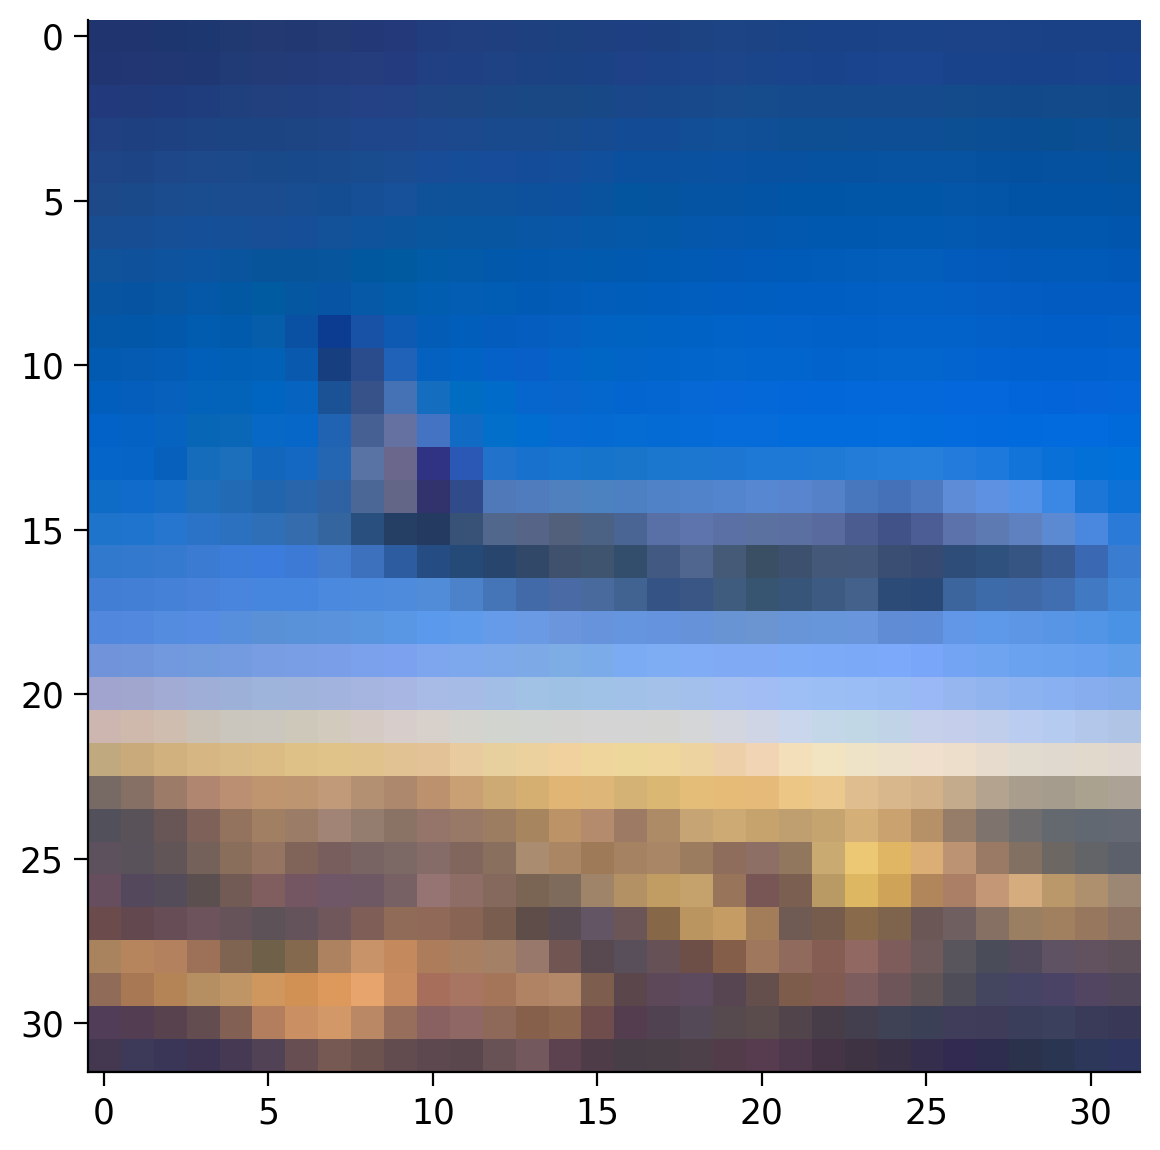

In [148]:
# Load the next batch
batch_images, batch_labels = next(iter(train_dataloader))
print('Batch size:', batch_images.shape)

# Display the first image from the batch
plt.imshow(batch_images[0].permute(1, 2, 0))
plt.show()

**Transformations**

Another useful feature when loading a dataset is applying transformations on the data - color conversions, normalization, cropping, rotation etc. There are many predefined transformations in the `torchvision.transforms` package and you can also combine them using the `Compose` transform. Checkout the [pytorch documentation](https://pytorch.org/vision/stable/transforms.html) for details.

### Coding Exercise 2.6: Load the CIFAR10 dataset as grayscale images

The goal of this excercise is to load the images from the CIFAR10 dataset as grayscale images. Note that we rerun the `set_seed` function to ensure reproducibility.

Random seed 2021 has been set.


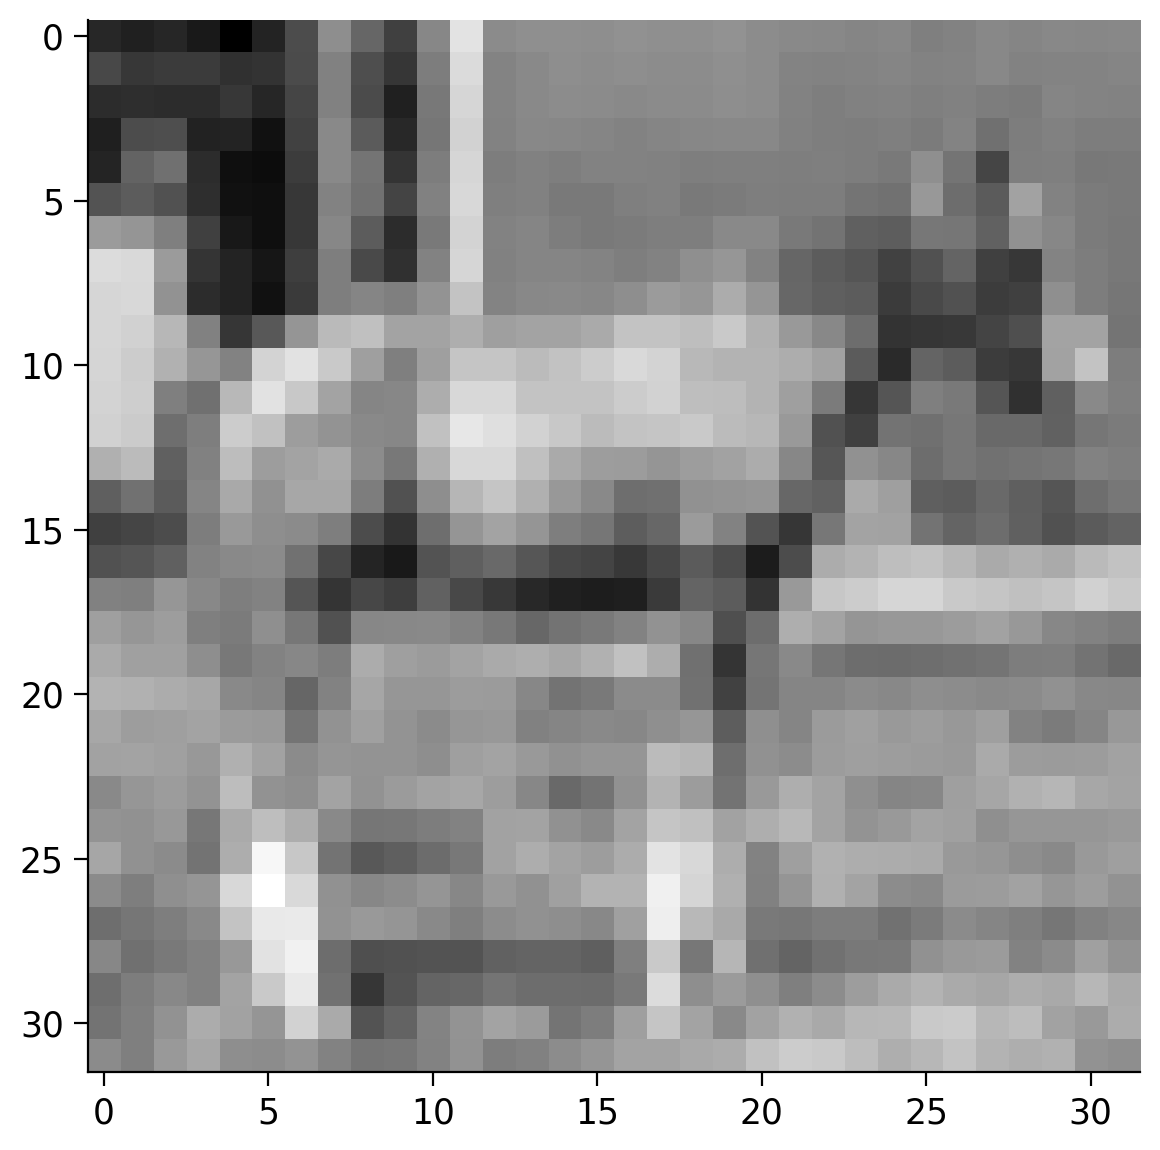

In [149]:
def my_data_load():
  """
  Function to load CIFAR10 data as grayscale images

  Args:
    None

  Returns:
    data: DataFrame
      CIFAR10 loaded Dataframe of shape (3309, 14)
  """
  ###############################################
  ## TODO for students: load the CIFAR10 data,
  ## but as grayscale images and not as RGB colored.
  # raise NotImplementedError("Student exercise: fill in the missing code to load the data")
  ###############################################
  ## TODO Load the CIFAR10 data using a transform that converts the images to grayscale tensors
  data = datasets.CIFAR10('data',train=True,download=True,transform=Compose([Grayscale(),ToTensor()]))
  # Display a random grayscale image
  image, label = data[random.randint(0, len(data))]
  plt.imshow(image.squeeze(), cmap="gray")
  plt.show()

  return data


set_seed(seed=2021)
## After implementing the above code, uncomment the following lines to test your code
data = my_data_load()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D1_BasicsAndPytorch/solutions/W1D1_Tutorial1_Solution_1c5a709e.py)

*Example output:*

<img alt='Solution hint' align='left' width=580.0 height=575.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D1_BasicsAndPytorch/static/W1D1_Tutorial1_Solution_1c5a709e_1.png>



In [150]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Load_CIFAR10_Exercise")

---
# Section 3: Neural Networks

*Time estimate: ~1 hour 30 mins (excluding video)*

Now it's time for you to create your first neural network using PyTorch. This section will walk you through the process of:

- Creating a simple neural network model
- Training the network
- Visualizing the results of the network
- Tweaking the network

In [151]:
# @title Video 10: CSV Files
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'JrC_UAJWYKU'), ('Bilibili', 'BV1xy4y1T7kv')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [152]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_CSV_files_Video")

## Section 3.1: Data Loading

First we need some sample data to train our network on. You can use the function below to generate an example dataset consisting of 2D points along two interleaving half circles. The data will be stored in a file called `sample_data.csv`. You can inspect the file directly in Colab by going to Files on the left side and opening the CSV file.

In [153]:
# @title Generate sample data
# @markdown we used `scikit-learn` module
from sklearn.datasets import make_moons

# Create a dataset of 256 points with a little noise
X, y = make_moons(256, noise=0.1)

# Store the data as a Pandas data frame and save it to a CSV file
df = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1], y=y))
df.to_csv('sample_data.csv')

Now we can load the data from the CSV file using the Pandas library. Pandas provides many functions for reading files in various formats. When loading data from a CSV file, we can reference the columns directly by their names.

Size X:(256, 2)
Size y:(256,)


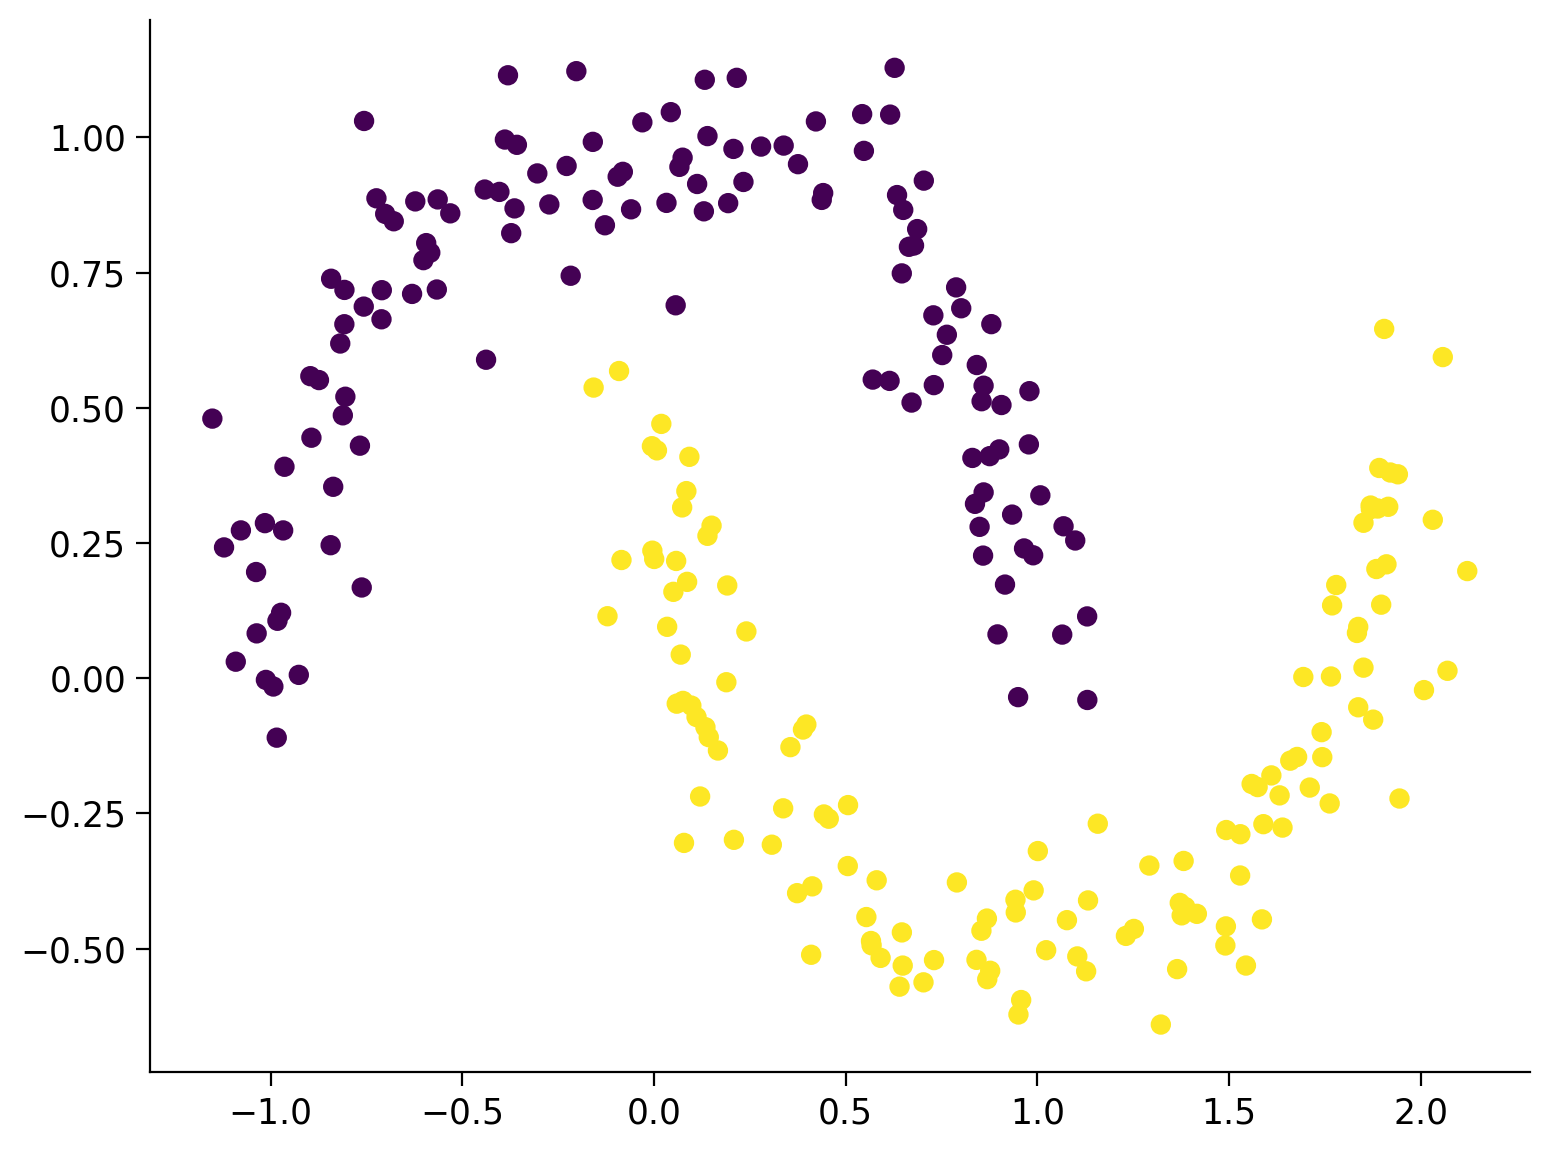

In [154]:
# Load the data from the CSV file in a Pandas DataFrame
data = pd.read_csv("sample_data.csv")

# Create a 2D numpy array from the x0 and x1 columns
X_orig = data[["x0", "x1"]].to_numpy()

# Create a 1D numpy array from the y column
y_orig = data["y"].to_numpy()

# Print the sizes of the generated 2D points X and the corresponding labels Y
print(f"Size X:{X_orig.shape}")
print(f"Size y:{y_orig.shape}")

# Visualize the dataset. The color of the points is determined by the labels `y_orig`.
plt.scatter(X_orig[:, 0], X_orig[:, 1], s=40, c=y_orig)
plt.show()

**Prepare Data for PyTorch**

Now let's prepare the data in a format suitable for PyTorch - convert everything into tensors.

In [155]:
# Initialize the device variable
DEVICE = set_device()

# Convert the 2D points to a float32 tensor
X = torch.tensor(X_orig, dtype=torch.float32)

# Upload the tensor to the device
X = X.to(DEVICE)

print(f"Size X:{X.shape}")

# Convert the labels to a long interger tensor
y = torch.from_numpy(y_orig).type(torch.LongTensor)

# Upload the tensor to the device
y = y.to(DEVICE)

print(f"Size y:{y.shape}")

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu
Size X:torch.Size([256, 2])
Size y:torch.Size([256])


## Section 3.2: Create a Simple Neural Network

In [156]:
# @title Video 11: Generating the Neural Network
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'PwSzRohUvck'), ('Bilibili', 'BV1fK4y1M74a')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [157]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Generating_Neural_Network_Video")

For this example we want to have a simple neural network consisting of 3 layers:

- 1 input layer of size 2 (our points have 2 coordinates)
- 1 hidden layer of size 16 (you can play with different numbers here)
- 1 output layer of size 2 (we want the have the scores for the two classes)

During the course you will deal with differend kinds of neural networks. On Day 2, we will focus on linear networks, but you will work with some more complicated architectures in the next days. The example here is meant to demonstrate the process of creating and training a neural network end-to-end.

**Programing the Network**

PyTorch provides a base class for all neural network modules called [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). You need to inherit from `nn.Module` and implement some important methods:

* `__init__`

  In the `__init__` method you need to define the structure of your network. Here you will specify what layers will the network consist of, what activation functions will be used etc.

* `forward`

  All neural network modules need to implement the `forward` method. It specifies the computations the network needs to do when data is passed through it.

* `predict`

  This is not an obligatory method of a neural network module, but it is a good practice if you want to quickly get the most likely label from the network. It calls the `forward` method and chooses the label with the highest score.

* `train`

  This is also not an obligatory method, but it is a good practice to have. The method will be used to train the network parameters and will be implemented later in the notebook.

<br>

**Note:** You can use the `__call__` method of a module directly and it will invoke the `forward` method: `net()` does the same as `net.forward()`.

In [158]:
# Inherit from nn.Module - the base class for neural network modules provided by Pytorch
class NaiveNet(nn.Module):
  """
  NaiveNet architecture
  Structure is as follows:
  Linear Layer (2, 16) -> ReLU activation -> Linear Layer (16, 2)
  """
  # Define the structure of your network
  def __init__(self):
    """
    Defines the NaiveNet structure by initialising following attributes
    nn.Linear (2, 16):  Transformation from the input to the hidden layer
    nn.ReLU: Activation function (ReLU) is a non-linearity which is widely used because it reduces computation.
             The function returns 0 if it receives any negative input, but for any positive value x, it returns that value back.
    nn.Linear (16, 2): Transformation from the hidden to the output layer

    Args:
      None

    Returns:
      Nothing
    """
    super(NaiveNet, self).__init__()

    # The network is defined as a sequence of operations
    self.layers = nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16, 2),
    )

  # Specify the computations performed on the data
  def forward(self, x):
    """
    Defines the forward pass through the above defined structure

    Args:
      x: torch.Tensor
        Input tensor of size ([3])

    Returns:
      layers: nn.module
        Initialised Layers in order to re-use the same layer for each forward pass of data you make.
    """
    # Pass the data through the layers
    return self.layers(x)

  # Choose the most likely label predicted by the network
  def predict(self, x):
    """
    Performs the prediction task of the network

    Args:
      x: torch.Tensor
        Input tensor of size ([3])

    Returns:
      Most likely class i.e., Label with the highest score
    """
    # Pass the data through the networks
    output = self.forward(x)

    # Choose the label with the highest score
    return torch.argmax(output, 1)

  # Train the neural network (will be implemented later)
  def train(self, X, y):
    """
    Training the Neural Network

    Args:
      X: torch.Tensor
        Input data
      y: torch.Tensor
        Class Labels/Targets

    Returns:
      Nothing
    """
    pass

**Check that your network works**

Create an instance of your model and visualize it.

In [159]:
# Create new NaiveNet and transfer it to the device
model = NaiveNet().to(DEVICE)

# Print the structure of the network
print(model)

NaiveNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)


### Coding Exercise 3.2: Classify some samples

Now, let's pass some of the points of our dataset through the network and see if it works. You should not expect the network to actually classify the points correctly, because it has not been trained yet.

The goal here is just to get some experience with the data structures that are passed to the forward and predict methods and their results.

In [187]:
## Get the samples
X_samples = X[:5]
print("Sample input:\n", X_samples)

## Do a forward pass of the network
output = model(X_samples)
print("\nNetwork output:\n", output)

## Predict the label of each point
y_predicted = model.predict(X_samples)
print("\nPredicted labels:\n", y_predicted)

Sample input:
 tensor([[ 0.9066,  0.5052],
        [-0.2024,  1.1226],
        [ 1.0685,  0.2809],
        [ 0.6720,  0.5097],
        [ 0.8548,  0.5122]])

Network output:
 tensor([[ 0.1543, -0.8018],
        [ 2.2077, -2.9859],
        [-0.5745, -0.0195],
        [ 0.1923, -0.8367],
        [ 0.1818, -0.8301]], grad_fn=<AddmmBackward0>)

Predicted labels:
 tensor([0, 0, 1, 0, 0])


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D1_BasicsAndPytorch/solutions/W1D1_Tutorial1_Solution_63f6a21a.py)



```
Sample input:
 tensor([[ 0.9066,  0.5052],
        [-0.2024,  1.1226],
        [ 1.0685,  0.2809],
        [ 0.6720,  0.5097],
        [ 0.8548,  0.5122]], device='cuda:0')

Network output:
 tensor([[ 0.1543, -0.8018],
        [ 2.2077, -2.9859],
        [-0.5745, -0.0195],
        [ 0.1924, -0.8367],
        [ 0.1818, -0.8301]], device='cuda:0', grad_fn=<AddmmBackward>)

Predicted labels:
 tensor([0, 0, 1, 0, 0], device='cuda:0')
```

In [161]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Classify_some_examples_Exercise")

## Section 3.3: Train Your Neural Network

In [162]:
# @title Video 12: Train the Network
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '4MIqnE4XPaA'), ('Bilibili', 'BV1v54y1n7CS')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [163]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Train_the_Network_Video")

Now it is time to train your network on your dataset. Don't worry if you don't fully understand everything yet - we will cover training in much more details in the next days. For now, the goal is just to see your network in action!

You will usually implement the `train` method directly when implementing your class `NaiveNet`. Here, we will implement it as a function outside of the class in order to have it in a separate cell.

In [164]:
# @title Helper function to plot the decision boundary

# Code adapted from this notebook: https://jonchar.net/notebooks/Artificial-Neural-Network-with-Keras/

from pathlib import Path

def plot_decision_boundary(model, X, y, device):
  """
  Helper function to plot decision boundary

  Args:
    model: nn.module
      NaiveNet instance
    X: torch.tensor
      Input CIFAR10 data
    y: torch.tensor
      Class Labels/Targets
    device: String
      "cpu" or "cuda"

  Returns:
    Nothing
  """
  # Transfer the data to the CPU
  X = X.cpu().numpy()
  y = y.cpu().numpy()

  # Check if the frames folder exists and create it if needed
  frames_path = Path("frames")
  if not frames_path.exists():
    frames_path.mkdir()

  # Set min and max values and give it some padding
  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
  h = 0.01

  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Predict the function value for the whole gid
  grid_points = np.c_[xx.ravel(), yy.ravel()]
  grid_points = torch.from_numpy(grid_points).type(torch.FloatTensor)
  Z = model.predict(grid_points.to(device)).cpu().numpy()
  Z = Z.reshape(xx.shape)

  # Plot the contour and training examples
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)

Epoch 0 loss is 0.6582635641098022
Epoch 1000 loss is 0.28303542733192444
Epoch 2000 loss is 0.24354353547096252
Epoch 3000 loss is 0.23178492486476898
Epoch 4000 loss is 0.22571028769016266
Epoch 5000 loss is 0.2219410240650177
Epoch 6000 loss is 0.21937935054302216
Epoch 7000 loss is 0.21753723919391632
Epoch 8000 loss is 0.21614308655261993
Epoch 9000 loss is 0.21508803963661194
Epoch 10000 loss is 0.21437253057956696
Epoch 11000 loss is 0.21384572982788086
Epoch 12000 loss is 0.21345031261444092
Epoch 13000 loss is 0.21314124763011932
Epoch 14000 loss is 0.2128836214542389


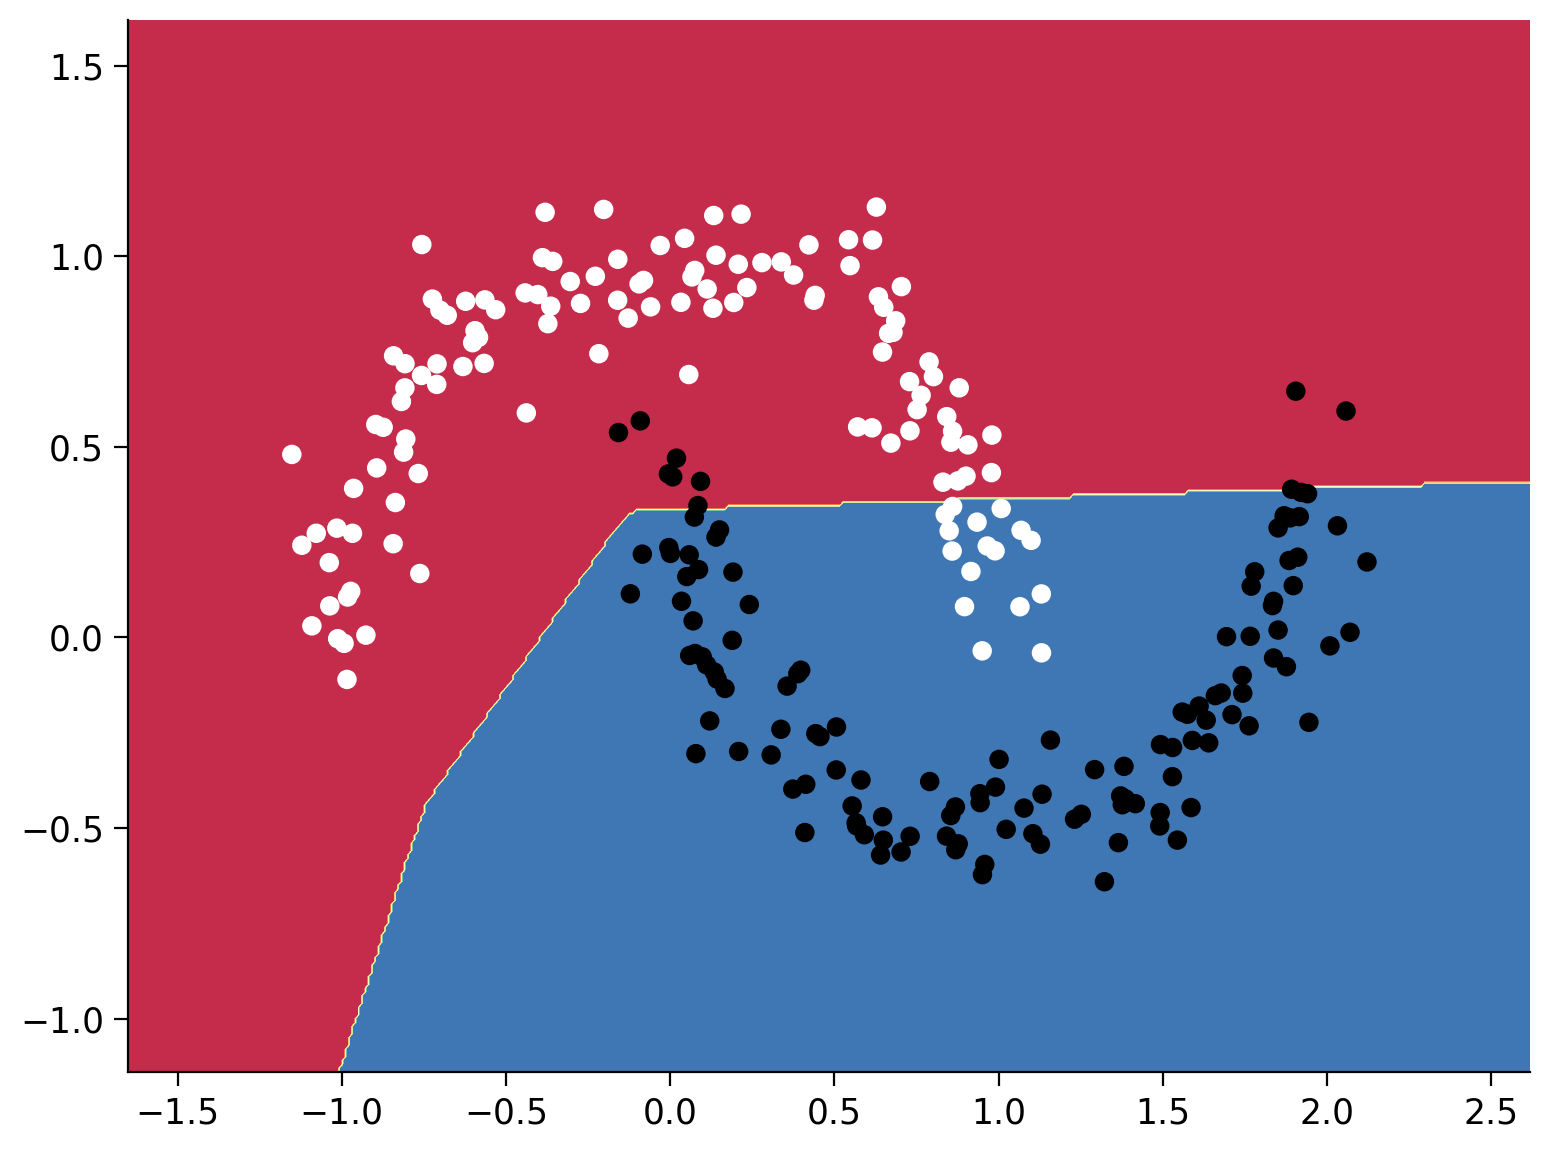

In [165]:
# Implement the train function given a training dataset X and correcsponding labels y
def train(model, X, y):
  """
    Training the Neural Network

    Args:
      X: torch.Tensor
        Input data
      y: torch.Tensor
        Class Labels/Targets

    Returns:
      losses: Float
        Cross Entropy Loss; Cross-entropy builds upon the idea of entropy
        from information theory and calculates the number of bits required
        to represent or transmit an average event from one distribution
        compared to another distribution.
    """
  # The Cross Entropy Loss is suitable for classification problems
  loss_function = nn.CrossEntropyLoss()

  # Create an optimizer (Stochastic Gradient Descent) that will be used to train the network
  learning_rate = 1e-2
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # Number of epochs
  epochs = 15000

  # List of losses for visualization
  losses = []

  for i in range(epochs):
    # Pass the data through the network and compute the loss
    # We'll use the whole dataset during the training instead of using batches
    # in to order to keep the code simple for now.
    y_logits = model.forward(X)
    loss = loss_function(y_logits, y)

    # Clear the previous gradients and compute the new ones
    optimizer.zero_grad()
    loss.backward()

    # Adapt the weights of the network
    optimizer.step()

    # Store the loss
    losses.append(loss.item())

    # Print the results at every 1000th epoch
    if i % 1000 == 0:
      print(f"Epoch {i} loss is {loss.item()}")

      plot_decision_boundary(model, X, y, DEVICE)
      plt.savefig('frames/{:05d}.png'.format(i))

  return losses


# Create a new network instance a train it
model = NaiveNet().to(DEVICE)
losses = train(model, X, y)

**Plot the loss during training**

Plot the loss during the training to see how it reduces and converges.

Text(0, 0.5, 'Loss')

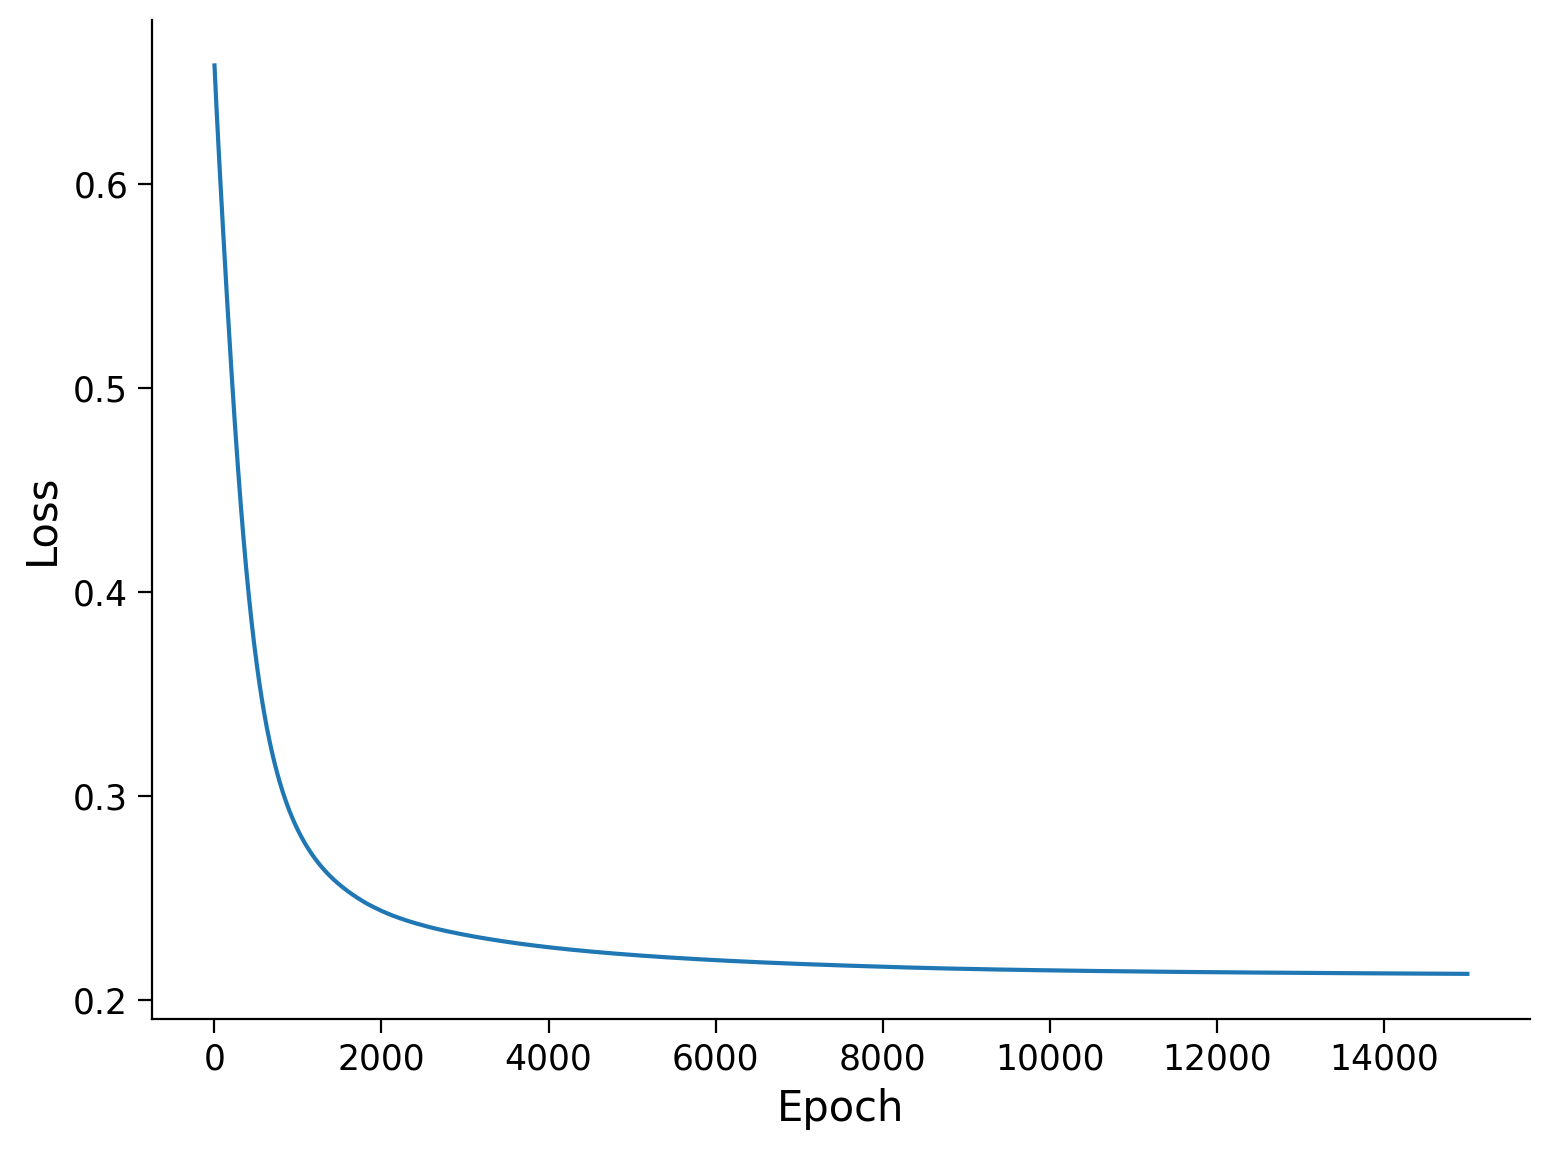

In [166]:
plt.plot(np.linspace(1, len(losses), len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

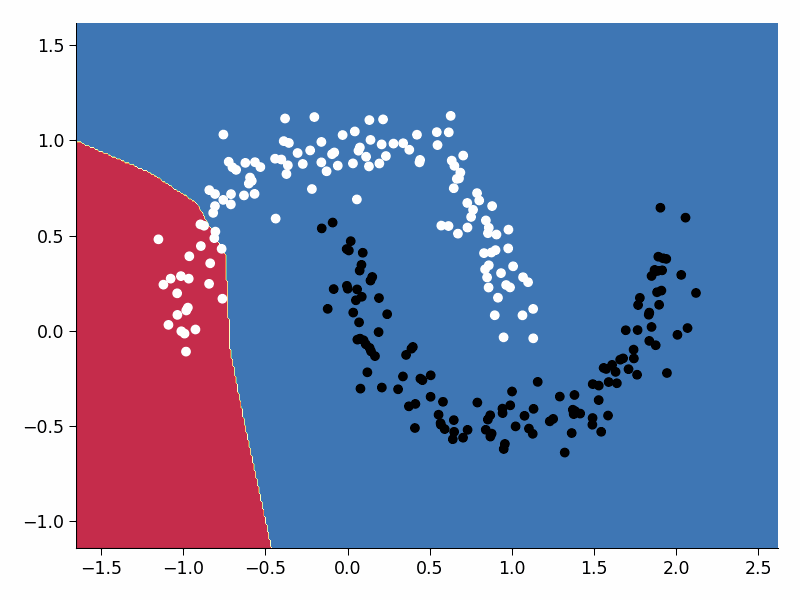

In [167]:
# @title Visualize the training process
# @markdown Execute this cell!
!pip install imageio --quiet
!pip install pathlib --quiet

import imageio.v2 as imageio
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Image, display
from pathlib import Path

InteractiveShell.ast_node_interactivity = "all"

# Make a list with all images
images = []
for i in range(10):
  filename = Path("frames/0"+str(i)+"000.png")
  images.append(imageio.imread(filename))
# Save the gif
imageio.mimsave('frames/movie.gif', images)
gifPath = Path("frames/movie.gif")
with open(gifPath,'rb') as f:
  display(Image(data=f.read(), format='png'))

In [168]:
# @title Video 13: Play with it
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '_GGkapdOdSY'), ('Bilibili', 'BV1Cq4y1W7BH')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [169]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Play_with_it_Video")

### Exercise 3.3: Tweak your Network

You can now play around with the network a little bit to get a feeling of what different parameters are doing. Here are some ideas what you could try:

- Increase or decrease the number of epochs for training
- Increase or decrease the size of the hidden layer
- Add one additional hidden layer

Can you get the network to better fit the data?

In [170]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Tweak_your_Network_Discussion")

In [171]:
# @title Video 14: XOR Widget
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'oTr1nE2rCWg'), ('Bilibili', 'BV1mB4y1N7QS')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [172]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_XOR_widget_Video")

Exclusive OR (XOR) logical operation gives a true (`1`) output when the number of true inputs is odd. That is, a true output result if one, and only one, of the inputs to the gate is true. If both inputs are false (`0`) or both are true or false output results. Mathematically speaking, XOR represents the inequality function, i.e., the output is true if the inputs are not alike; otherwise, the output is false.

In case of two inputs ($X$ and $Y$) the following truth table is applied:

\begin{matrix}
  X & Y & \text{XOR}\\
  \hline
  0 & 0 & 0\\
  0 & 1 & 1\\
  1 & 0 & 1\\
  1 & 1 & 0
\end{matrix}

Here, with `0`, we denote `False`, and with `1` we denote `True` in boolean terms.

### Interactive Demo 3.3: Solving XOR

Here we use an open source and famous visualization widget developed by Tensorflow team available [here](https://github.com/tensorflow/playground).
* Play with the widget and observe if you can solve the continuous XOR dataset.
* Now add one hidden layer with three units, play with the widget, and set weights by hand to solve this dataset perfectly.

For the second part, you should set the weights by clicking on the connections and either type the value or use the up and down keys to change it by one increment. You could also do the same for the biases by clicking on the tiny square to each neuron's bottom left.
Even though there are infinitely many solutions, a neat solution when $f(x)$ is ReLU is:

\begin{equation}
  y = f(x_1)+f(x_2)-f(x_1+x_2)
\end{equation}

Try to set the weights and biases to implement this function after you played enough :)

In [173]:
# @markdown Play with the parameters to solve XOR
from IPython.display import IFrame
from ipywidgets import widgets
url = 'https://playground.arashash.com/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.91390&showTestData=false&discretize=false&percTrainData=90&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false'
url2 = "https://playground.arashash.com"
out = widgets.Output()
with out:
  print(f"If you want to vist the webpage: {url2}")
  display(IFrame(src=f"{url}", width=1020, height=660))
display(out)

Output()

In [174]:
# @markdown Do you think we can solve the discrete XOR (only 4 possibilities) with only 2 hidden units?
w1_min_xor = 'Select' # @param ['Select', 'Yes', 'No']
if w1_min_xor == 'Yes':
  print("Awesome. Indeed, yes. We take the two points for which the output should be 1 and dedicate one of the hidden units to each of them. Each of theses  ReLU functions are diagonal and tuned so that only for one of those two points the output is 1. In the end, we add these two together. And voila - discrete xor.")
elif w1_min_xor == 'No':
  print("How about giving it another try?")
else:
  print("Select 'Yes' or 'No'!")

Select 'Yes' or 'No'!


In [175]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_XOR_Interactive_Demo")

---
# Section 4: Ethics And Course Info

In [176]:
# @title Video 15: Ethics
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'Kt6JLi3rUFU'), ('Bilibili', 'BV1Hw41197oB')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [177]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Ethics_Video")

In [178]:
# @title Video 16: Be a group
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'Sfp6--d_H1A'), ('Bilibili', 'BV1j44y1272h')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [179]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Be_a_group_Video")

In [180]:
# @title Video 17: Syllabus
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'cDvAqG_hAvQ'), ('Bilibili', 'BV1iB4y1N7uQ')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [181]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Syllabus_Video")

## Meet our lecturers

### Week 1: the building blocks
* [Konrad Kording](https://kordinglab.com)
* [Andrew Saxe](https://www.saxelab.org/)
* [Surya Ganguli](https://ganguli-gang.stanford.edu/)
* [Ioannis Mitliagkas](http://mitliagkas.github.io/)
* [Lyle Ungar](https://www.cis.upenn.edu/~ungar/)

### Week 2: making things work
* [Alona Fyshe](https://webdocs.cs.ualberta.ca/~alona/)
* [Alexander Ecker](https://eckerlab.org/)
* [James Evans](https://sociology.uchicago.edu/directory/james-evans)
* [He He](https://hhexiy.github.io/)
* [Vikash Gilja](https://tnel.ucsd.edu/bio) and [Akash Srivastava](https://akashgit.github.io/)

### Week 3: more magic
* [Tim Lillicrap](https://contrastiveconvergence.net/~timothylillicrap/index.php) and [Blake Richards](https://www.mcgill.ca/neuro/blake-richards-phd)
* [Jane Wang](http://www.janexwang.com/) and [Feryal Behbahani](https://feryal.github.io/)
* [Tim Lillicrap](https://contrastiveconvergence.net/~timothylillicrap/index.php) and [Blake Richards](https://www.mcgill.ca/neuro/blake-richards-phd)
* [Josh Vogelstein](https://jovo.me/) and [Vincenzo Lamonaco](https://www.vincenzolomonaco.com/)

Now, go to the [visualization of ICLR papers](https://iclr.cc/virtual/2021/paper_vis.html). Read a few abstracts. Look at the various clusters. Where do you see yourself in this map?

---
# Daily survey

Don't forget to complete your reflections and content check in the daily survey! Please be patient after logging in as there is
a small delay before you will be redirected to the survey.

<a href="https://portal.neuromatchacademy.org/api/redirect/to/f2da6480-069c-49b9-a37b-8750f9d6f359"><img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/SurveyButton.png?raw=1" alt="button link to survey" style="width:410px"></a>

---
# Bonus - 60 years of Machine Learning Research in one Plot

By [Hendrik Strobelt](http://hendrik.strobelt.com) (MIT-IBM Watson AI Lab) with support from Benjamin Hoover.

In this notebook we visualize a subset* of 3,300 articles retreived from the AllenAI [S2ORC dataset](https://github.com/allenai/s2orc). We represent each paper by a position that is output of a dimensionality reduction method applied to a vector representation of each paper. The vector representation is the output of a neural network.

**Note:** The selection is very biased on the keywords and methodology we used to filter. Please see the details section to learn about what we did.

In [182]:
# @title Install and Import `altair` and `vega_datasets`.
!pip install altair vega_datasets --quiet

import altair as alt  # altair is defining data visualizations

# Source data files
# Position data file maps ID to x,y positions
# original link: http://gltr.io/temp/ml_regexv1_cs_ma_citation+_99perc.pos_umap_cosine_100_d0.1.json
POS_FILE = 'https://osf.io/qyrfn/download'
# original link: http://gltr.io/temp/ml_regexv1_cs_ma_citation+_99perc_clean.csv
# Metadata file maps ID to title, abstract, author,....
META_FILE = 'https://osf.io/vfdu6/download'

# data loading and wrangling
def load_data():
  """
  Loading the data

  Args:
    None

  Returns:
    Merged read dataFrame combining id and paper_id;
  """
  positions = pd.read_json(POS_FILE)
  positions[['x', 'y']] = positions['pos'].to_list()
  meta = pd.read_csv(META_FILE)
  return positions.merge(meta, left_on='id', right_on='paper_id')


# load data
data = load_data()

In [183]:
# @title Define Visualization using ALtair
YEAR_PERIOD = "quinquennial"  # @param
selection = alt.selection_multi(fields=[YEAR_PERIOD], bind='legend')
data[YEAR_PERIOD] = (data["year"] / 5.0).apply(np.floor) * 5
chart = alt.Chart(data[["x", "y", "authors", "title", YEAR_PERIOD, "citation_count"]], width=800,
                  height=800).mark_circle(radius=2, opacity=0.2).encode(
    alt.Color(YEAR_PERIOD+':O',
              scale=alt.Scale(scheme='viridis', reverse=False, clamp=True, domain=list(range(1955,2020,5))),
              # legend=alt.Legend(title='Total Records')
              ),
    alt.Size('citation_count',
              scale=alt.Scale(type="pow", exponent=1, range=[15, 300])
              ),
       alt.X('x:Q',
        scale=alt.Scale(zero=False), axis=alt.Axis(labels=False)
    ),
       alt.Y('y:Q',
        scale=alt.Scale(zero=False), axis=alt.Axis(labels=False)
    ),
    tooltip=['title', 'authors'],
    # size='citation_count',
    # color="decade:O",
    opacity=alt.condition(selection, alt.value(.8), alt.value(0.2)),

).add_selection(
    selection
).interactive()

/tmp/ipython-input-183-235004507.py:3: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  selection = alt.selection_multi(fields=[YEAR_PERIOD], bind='legend')
/tmp/ipython-input-183-235004507.py:25: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  ).add_selection(


Lets look at the Visualization. Each dot represents one paper. Close dots mean that the respective papers are closer related than distant ones. The color indicates the 5-year period of when the paper was published. The dot size indicates the citation count (within S2ORC corpus) as of July 2020.

The view is **interactive** and allows for three main interactions. Try them and play around:
1. Hover over a dot to see a tooltip (title, author)
2. Select a year in the legend (right) to filter dots
3. Zoom in/out with scroll -- double click resets view

In [184]:
chart

alt.Chart(...)

## Questions

By playing around, can you find some answers to the following questions?

1. Can you find topical clusters? What cluster might occur because of a filtering error?
2. Can you see a temporal trend in the data and clusters?
3. Can you determine when deep learning methods started booming ?
4. Can you find the key papers that where written before the DL "winter" that define milestones for a cluster? (tip: look for large dots of different color)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D1_BasicsAndPytorch/solutions/W1D1_Tutorial1_Solution_21a88cd0.py)



In [185]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Bonus_Section_Discussion")

## Methods

Here is what we did:
1. Filtering of all papers who fullfilled the criterria:
  - are categorized as `Computer Science` or `Mathematics`
  - one of the following keywords appearing in title or abstract: `"machine learning|artificial intelligence|neural network|(machine|computer) vision|perceptron|network architecture| RNN | CNN | LSTM | BLEU | MNIST | CIFAR |reinforcement learning|gradient descent| Imagenet "`
2. Per year, remove all papers that are below the 99 percentile of citation count in that year
3. Embed each paper by using abstract + title in SPECTER model
4. Project based on embedding using UMAP
5. Visualize using Altair

### Find Authors

In [186]:
# @title Edit the `AUTHOR_FILTER` variable to full text search for authors.

AUTHOR_FILTER = "Rush "  # @param space at the end means "word border"

### Don't ignore case when searching...
FLAGS = 0
### uncomment do ignore case
# FLAGS = re.IGNORECASE

## --- FILTER CODE.. make it your own ---
data['issel'] = data['authors'].str.contains(AUTHOR_FILTER, na=False, flags=FLAGS, )
if data['issel'].mean()<0.0000000001:
  print('No match found')

## --- FROM HERE ON VIS CODE ---
alt.Chart(data[["x", "y", "authors", "title", YEAR_PERIOD, "citation_count", "issel"]], width=800,
                  height=800) \
    .mark_circle(stroke="black", strokeOpacity=1).encode(
    alt.Color(YEAR_PERIOD+':O',
              scale=alt.Scale(scheme='viridis', reverse=False),
              # legend=alt.Legend(title='Total Records')
              ),
    alt.Size('citation_count',
              scale=alt.Scale(type="pow", exponent=1, range=[15, 300])
              ),
    alt.StrokeWidth('issel:Q', scale=alt.Scale(type="linear", domain=[0,1], range=[0, 2]), legend=None),

    alt.Opacity('issel:Q', scale=alt.Scale(type="linear", domain=[0,1], range=[.2, 1]), legend=None),
    alt.X('x:Q',
        scale=alt.Scale(zero=False), axis=alt.Axis(labels=False)
    ),
    alt.Y('y:Q',
        scale=alt.Scale(zero=False), axis=alt.Axis(labels=False)
    ),
    tooltip=['title', 'authors'],
).interactive()

alt.Chart(...)

---
# Appendix

## Official PyTorch resources:

### Tutorials
- [https://pytorch.org/tutorials/](https://pytorch.org/tutorials/)

### Documentation
- [https://pytorch.org/docs/stable/tensors.html](https://pytorch.org/docs/stable/tensors.html) (tensor methods)

- [https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view) (The view method in particular)

- [https://pytorch.org/vision/stable/datasets.html](https://pytorch.org/vision/stable/datasets.html) (pre-loaded image datasets)

## Google Colab Resources:
- [https://research.google.com/colaboratory/faq.html](https://research.google.com/colaboratory/faq.html) (FAQ including guidance on GPU usage)

## Books for reference:
- [https://www.deeplearningbook.org/](https://www.deeplearningbook.org/) (Deep Learning by Ian Goodfellow, Yoshua Bengio and Aaron Courville)